## Handwritten Equation Solver
Implementing a basic algorithm to create a calculator model, that can evaluate an expression in
a given image.


In [ ]:
!pip install imutils

In [2]:
# importing libraries used for the model
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils

In [ ]:
# using keras for building the architecture of convolutional neural net
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
# loading training and validation data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.25
)

data_path='../input/calculator/All data (Compressed)'
train_set = train_datagen.flow_from_directory(
    data_path,
    target_size = (40, 40),
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    subset='training',
    seed = 123
)
valid_set = train_datagen.flow_from_directory(
    data_path,
    target_size = (40, 40),
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    subset='validation',
    seed = 123
)

Found 250428 images belonging to 16 classes.
Found 83467 images belonging to 16 classes.


In [ ]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='softmax'))
adam = tf.keras.optimizers.Adam(lr = 5e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# calculate loss and accuracy on both training and validation set
model.fit(train_set,validation_data=valid_set,epochs=2, verbose=1)

Epoch 1/2
7826/7826 [==============================] - 619s 79ms/step - loss: 0.1135 - accuracy: 0.9612 - val_loss: 0.2142 - val_accuracy: 0.9367
Epoch 2/2
7826/7826 [==============================] - 619s 79ms/step - loss: 0.1001 - accuracy: 0.9658 - val_loss: 0.2312 - val_accuracy: 0.9356


In [ ]:
def prediction(img):
    plt.imshow(img, cmap = 'gray')
    img = cv2.resize(img,(40, 40))
    norm_image = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.reshape((norm_image.shape[0], norm_image.shape[1], 1))
    case = np.asarray([norm_image])
    pred = model.predict_classes([case])
    print(pred)

    return ([i for i in train_set.class_indices if train_set.class_indices[i]==(pred[0])][0],pred)

In [ ]:
label_map = (train_set.class_indices)
label_map

{'%': 0,
 '*': 1,
 '+': 2,
 '-': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 '[': 14,
 ']': 15}

[11]
[11]
[2]
[7]
[6]


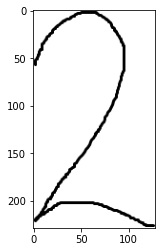

In [ ]:
# read the test image
image = cv2.imread('../input/test-data/test.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
# contour plotting to recognise a digit or operator in an image
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# draw a rectangular box around the recognised digit and opertor in the image
chars=[]
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if w*h>1200:
        roi = gray[y:y + h, x:x + w]
        chars.append(prediction(roi))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

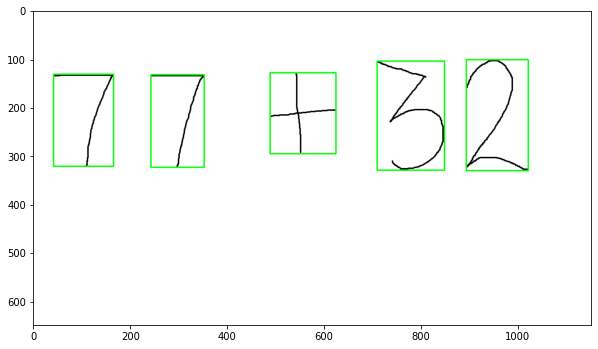

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)

In [ ]:
# chars is list of predicted digit/operator and their corresponding index
chars

[('7', array([11])),
 ('7', array([11])),
 ('+', array([2])),
 ('3', array([7])),
 ('2', array([6]))]

In [ ]:
labels=[i for i in train_set.class_indices]
print(labels)

['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']']


In [ ]:
# a is a list of all the digits and operators that are involved in the expression given, as test image
# b is a list which consist of values of length, of a, at which an operator is found
a = []
b = []
for i in ((chars)):
    if len(a)==0 and i[0][0] in labels[3:]:
        a.append(i[0][0])
    elif len(a)>0 and i[0][0] in labels[4:14]:
        a.append(i[0][0])
    elif len(a)>0 and i[0][0] in labels[:4]:
        a.append(i[0][0])
        b.append(len(a))
    else:
        pass

In [ ]:
# implement the calculator after image recognition
x = 0
for i in b:
    if a[i-1]=='+':
        if ((b.index(i))==0 and len(b)==1):
            x =  (int(''.join(a[:i-1]))) + (int(''.join(a[i:])))
        elif ((b.index(i)) == 0):
            x = (int(''.join(a[:i-1]))) + (int(''.join(a[i : (b[1]-1)])))
        elif (((b.index(i)) > 0) & (b.index(i)) != (len(b)-1)):
            x = x + (int(''.join(a[i : (b[b.index(i)+1]-1)])))
        elif (b.index(i) == (len(b)-1)):
            x = x + (int(''.join(a[i : len(a)])))
    elif a[i-1]=='%':
        if ((b.index(i))==0 and len(b)==1):
            x =  (int(''.join(a[:i-1]))) / (int(''.join(a[i:])))
        elif ((b.index(i)) == 0):
            x = (int(''.join(a[:i-1]))) / (int(''.join(a[i : (b[1]-1)])))
        elif (((b.index(i)) > 0) & (b.index(i)) != (len(b)-1)):
            x = x  / (int(''.join(a[i : (b[b.index(i)+1]-1)])))
        elif (b.index(i) == (len(b)-1)):
            x = x  / (int(''.join(a[i : len(a)])))
    elif a[i-1]=='*':
        if ((b.index(i))==0 and len(b)==1):
            x =  (int(''.join(a[:i-1]))) * (int(''.join(a[i:])))
        elif ((b.index(i)) == 0):
            x = (int(''.join(a[:i-1]))) * (int(''.join(a[i : (b[1]-1)])))
        elif (((b.index(i)) > 0) & (b.index(i)) != (len(b)-1)):
            x = x  * (int(''.join(a[i : (b[b.index(i)+1]-1)])))
        elif (b.index(i) == (len(b)-1)):
            x = x  * (int(''.join(a[i :])))
    else:
        if ((b.index(i))==0 and len(b)==1):
            x =  (int(''.join(a[:i-1]))) - (int(''.join(a[i:])))
        elif ((b.index(i)) == 0):
            x = (int(''.join(a[:i-1]))) - (int(''.join(a[i : (b[1]-1)])))
        elif (((b.index(i)) > 0) & (b.index(i)) != (len(b)-1)):
            x = x  - (int(''.join(a[i : (b[b.index(i)+1]-1)])))
        elif (b.index(i) == (len(b)-1)):
            x = x  - (int(''.join(a[i : len(a)])))
print('The result of given operation is - ')
print(x)

The result of given operation is - 
109
